# Dimensionality reduction 1

__Week 2 - 4 May 2022__

Practice applying and using dimensionality rediuction for analysing datasets with Principal Component Analysis (`PCA` & `Kernel PCA`).

---
### Data

The dataset is a photometric catalogue of galaxies. These galaxies were found in the 2-square degree field on the sky called COSMOS by space- and ground-based telescopes.

The radiation flux (energy per second) of each galaxy is measured in 8 bands (i.e. wavelengths of light) that span the spectrum from <span style="color:blue;">blue</span> to <span style="color:rgb(192,4,1,1);">infrared</span>: `u, r, z++, yHSC, H, Ks, SPLASH1, SPLASH2`. The fluxes are not corrected for any effects, such as distance to a galaxy, therefore there is a systematic effect in their measurements (called redshift).

So, in addition to its photometry each galaxy has its observed bias and physical properties:
* `redshift`$^1$ - systematic bias in flux measurements.
* `log_mass` - stellar mass in units of $log_{10}$ (inferred from a combination of fluxes and redshifts).
* `log_sfr` - rate of star formation in units of $log_{10}$ (inferred from a combination of fluxes and redshifts).
* `is_star_forming` - classification, based on galaxy colours (inferred from a combinations of fluxes and redshifts).

<span style="font-size:0.9em;"> $^1$ - redshift is the reddening of light that is proportianal to the velocity of an object receding away. On the sky, object velocities are proportional to their distances from us ([find out more](https://www.anisotropela.dk/encyclo/redshift.html)). </span>

---
### Exercise

Analyze the galaxy catalogue applying dimensionality reduction to galaxy fluxes.

* Apply `PCA` to fluxes. Can you find a base of principal compoenents that separates galaxies into star forming and dead? Does PCA give you a way to differentiate between various properties of galaxies?
* Think about preprocessing the data, if you haven't yet, and see if you can find a more representative set of principal components.
* Apply `Kernel PCA` afterwards. Does this give you a more meaningful vector space? If so, why?
* Apply `t-SNE`. Does it give you a cleaner separation between objects with different properties?
* Apply `UMAP`, for comparison.

---
* Authors:  Vadim Rusakov, Charles Steinhardt
* Email:  vadim.rusakov@nbi.ku.dk
* Date:   27th of April 2022

In [1]:
!conda install -c conda-forge umap-learn

'conda' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA, KernelPCA

### Part 1. Wine data set.

Let's take a look at the wine data set and practice finding the underlying classes of data using simple Principle Component Analysis. 

What's the "Wine data set"? It is a clean multi-variate set used to demonstrate classification algorithms. There are 13 features:

`1.  Alcohol`\
`2.  Malic acid`\
`3.  Ash`\
`4.  Alcalinity of ash`\
`5.  Magnesium`\
`6.  Total phenols`\
`7.  Flavanoids`\
`8.  Nonflavanoid phenols`\
`9.  Proanthocyanins`\
`10. Color intensity`\
`11. Hue`\
`12. OD280/OD315 of diluted wines`\
`13. Proline`

The data set is small and contains three classes of objects, each with a fairly well-defined feature space. These features have largely linear relationships, which makes it well-suited for demonstrating how PCA works.

Source: https://archive.ics.uci.edu/ml/datasets/wine.

In [3]:
# a quick function for plotting our PCA components
def plot_pca(y_pcs, y, fig = None, ax = None):
    #=== plot PCA results
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5), dpi=100)
    #ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
    #ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

    # locate the points of each type in the original data
    # and paint them over the transformed data
    is_type1 = (y == 0)
    is_type2 = (y == 1)
    is_type3 = (y == 2)
    ax.scatter(y_pcs[is_type1, 0], y_pcs[is_type1, 1], 
               c='y', marker='s', label='Type 1')
    ax.scatter(y_pcs[is_type2, 0], y_pcs[is_type2, 1], 
               c='b', marker='o', label='Type 2')
    ax.scatter(y_pcs[is_type3, 0], y_pcs[is_type3, 1], 
               c='g', marker='^', label='Type 3')
    ax.legend()
    #plt.show()
    return 

First, load the data, split it into features `X` and labels `y`. Then apply PCA to it and plot the results:

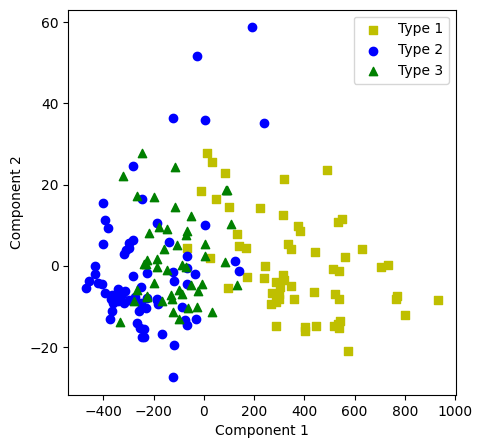

In [4]:
# load the wine dataset
data = load_wine()
X = data['data']
y = data['target']

pca = PCA(n_components=2, svd_solver='full') # get a pca object of class PCA()
y_pcs = pca.fit_transform(X) # train pca object

# plot PCA results
plot_pca(y_pcs, y)

Ok, the three groups do not appear to be distinct. However, we would expect for these classes to have distinct principal components. So something does not quite work. Remember to check the distributions of variables:

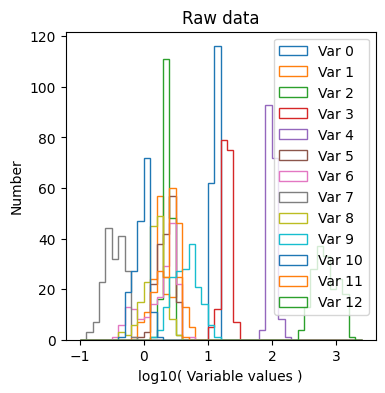

In [5]:
fig, ax = plt.subplots(1, figsize=(4, 4), dpi=100)
ax.set_xlabel('log10( Variable values )')
ax.set_ylabel('Number')
ax.set_title('Raw data')
xbins = np.arange(-1, 3.5, 0.1)

for i in range(X.shape[1]):
    ax.hist(np.log10(X[:, i]), bins=xbins, histtype='step', label=f'Var {i}')

ax.legend()
plt.show()

As you can see that the distributions of variables are normalized very differently. Let's fix it and try again:

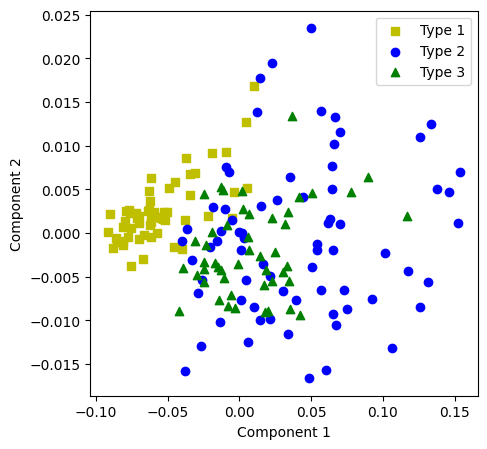

In [6]:
# normalize X
transform = preprocessing.Normalizer(norm='l2')
X_norm = transform.fit_transform(X)

# transform X_norm
y_pcs = pca.fit_transform(X_norm) # train pca object

# plot new PCA results
plot_pca(y_pcs, y)

Still does not work. Let's see those new distributions:

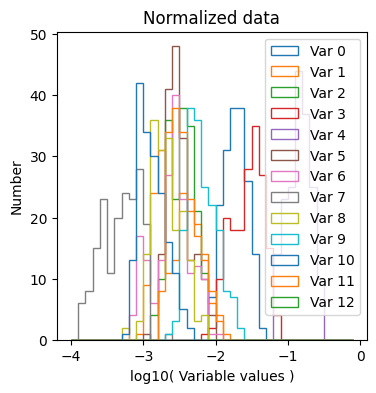

In [7]:
fig, ax = plt.subplots(1, figsize=(4, 4), dpi=100)
ax.set_xlabel('log10( Variable values )')
ax.set_ylabel('Number')
ax.set_title('Normalized data')
xbins = np.arange(-4, 0, 0.1)

for i in range(X.shape[1]):
    x_pos = X_norm[:, i][X_norm[:, i] > 0.0]
    ax.hist(np.log10(x_pos), bins=xbins, histtype='step', label=f'Var {i}')

ax.legend()
plt.show()

They are centered similarly, but seem to have different scales. Can we do better by scaling them similarly in addition to normalizing (i.e., standardizing them)? Looks much better. 

c:\Users\Simon Andersen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_data.py:2627: UserWarning: n_quantiles (1000) is greater than the total number of samples (178). n_quantiles is set to n_samples.
  warnings.warn(


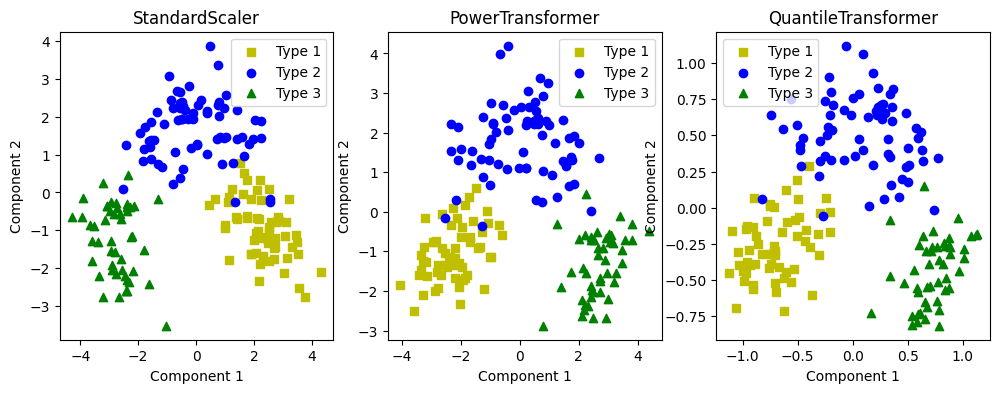

In [8]:
# standardize X using a variety of preprocessing schemes

transform = preprocessing.StandardScaler()
transform_list = [preprocessing.StandardScaler(), preprocessing.PowerTransformer(), preprocessing.QuantileTransformer()]
name_list = ['StandardScaler', 'PowerTransformer', 'QuantileTransformer']
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize=(12,4))
ax = ax.flatten()
for i,transform in enumerate(transform_list):
    # transform X_std
    X_std = transform.fit_transform(X)
    y_pcs = pca.fit_transform(X_std) # train pca object
    ax[i].set(title = f'{name_list[i]}')
    # plot new PCA results
    plot_pca(y_pcs, y, fig, ax[i])

See, the distributions are much more similar now. You can play around with other data transformers too. You may want to think about whether you have any outliers and how to deal with them. Also, sometimes variables can have different underlying distributions and therefore need to be transformed to the same (ideally, symmetric and standardized) distribution. Here is the link:

https://scikit-learn.org/stable/modules/preprocessing.html

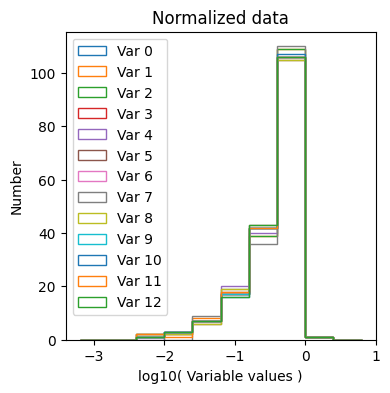

In [9]:
fig, ax = plt.subplots(1, figsize=(4, 4), dpi=100)
ax.set_xlabel('log10( Variable values )')
ax.set_ylabel('Number')
ax.set_title('Normalized data')
xbins = np.arange(-3.2, 1.0, 0.4)

for i in range(X.shape[1]):
    x_pos = X_std[:, i][X_std[:, i] > 0.0]
    ax.hist(np.log10(x_pos), bins=xbins, histtype='step', label=f'Var {i}')

ax.legend(loc=2)
plt.show()

Finally, we can comoute the principal components using a non-linear kernel, which can slightly improve the classification in this case. 

`KernelPCA` is a variant of the PCA, which can use a range of kernels for non-linear operations. I.e., this extension gives flexibility in separating the data that are not linearly-separable. Make sure to try different kernels for reducing the dimensionality. See documentation for `KernelPCA` in **sklearn**.

For Kernel PCA see the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA).

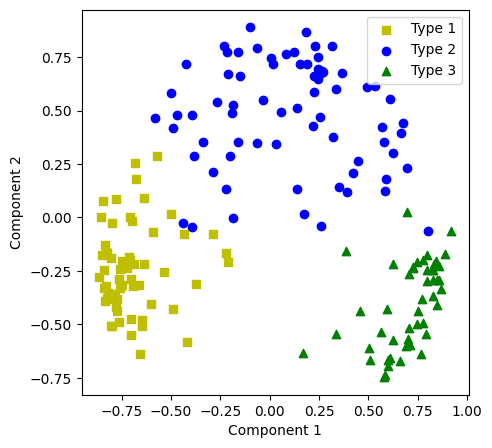

In [10]:
# standardize X
transform = preprocessing.StandardScaler()
X_std = transform.fit_transform(X)

# transform X_norm
kpca = KernelPCA(n_components=2, kernel='cosine')
y_pcs = kpca.fit_transform(X_std)


#plot new PCA results
plot_pca(y_pcs, y)

### Part 2. "Galaxies" data set.

Can you find odd samples that are mixed into the data?

Load in the data:

In [11]:
file = "datasets/cosmos2015_outliers.csv"
df_orig = pd.read_csv(file, index_col=False)
df_orig.info()
df_orig.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   redshift         10000 non-null  float64
 1   log_sfr          10000 non-null  float64
 2   log_mass         10000 non-null  float64
 3   is_star_forming  10000 non-null  int64  
 4   u_flux           10000 non-null  float64
 5   r_flux           10000 non-null  float64
 6   zpp_flux         10000 non-null  float64
 7   yhsc_flux        10000 non-null  float64
 8   h_flux           10000 non-null  float64
 9   ks_flux          10000 non-null  float64
 10  splash1_flux     10000 non-null  float64
 11  splash2_flux     10000 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 937.6 KB


Index(['redshift', 'log_sfr', 'log_mass', 'is_star_forming', 'u_flux',
       'r_flux', 'zpp_flux', 'yhsc_flux', 'h_flux', 'ks_flux', 'splash1_flux',
       'splash2_flux'],
      dtype='object')

array([[<Axes: title={'center': 'redshift'}>,
        <Axes: title={'center': 'log_sfr'}>,
        <Axes: title={'center': 'log_mass'}>],
       [<Axes: title={'center': 'is_star_forming'}>,
        <Axes: title={'center': 'u_flux'}>,
        <Axes: title={'center': 'r_flux'}>],
       [<Axes: title={'center': 'zpp_flux'}>,
        <Axes: title={'center': 'yhsc_flux'}>,
        <Axes: title={'center': 'h_flux'}>],
       [<Axes: title={'center': 'ks_flux'}>,
        <Axes: title={'center': 'splash1_flux'}>,
        <Axes: title={'center': 'splash2_flux'}>]], dtype=object)

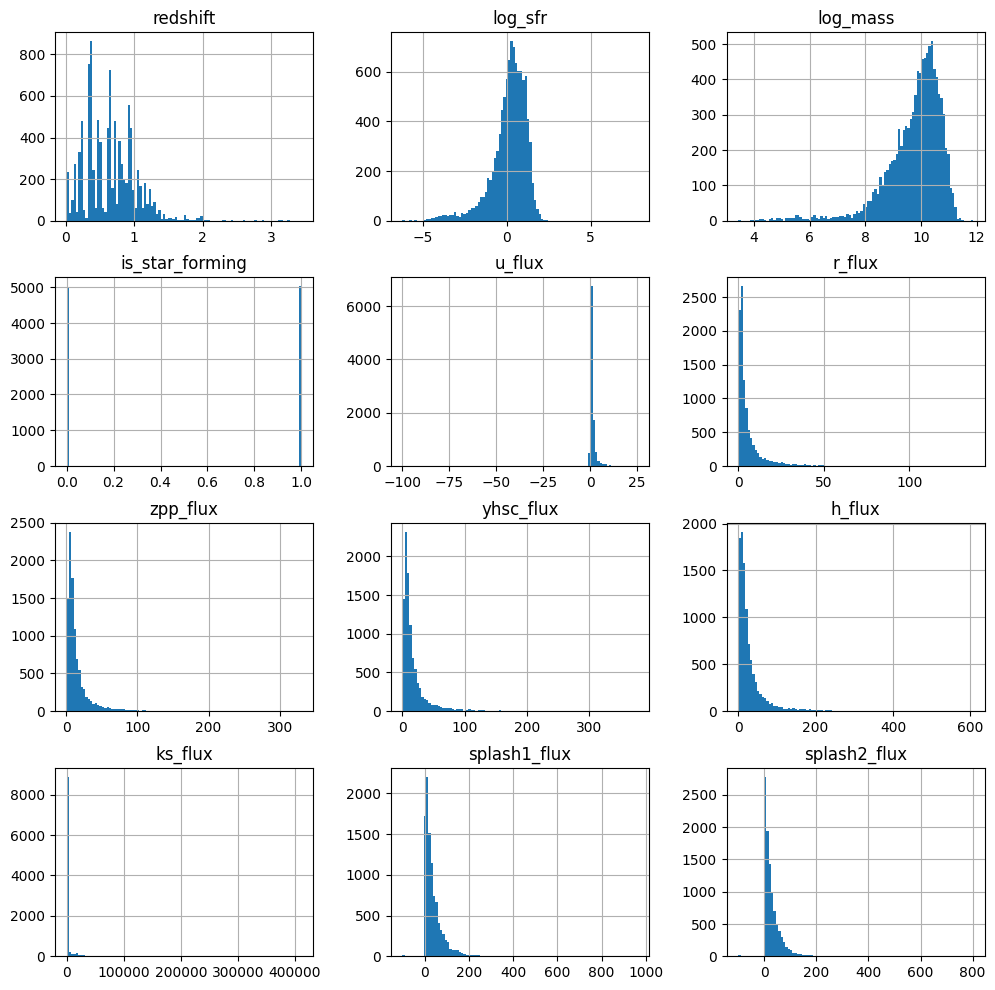

In [12]:
import seaborn as sns
#sns.pairplot(df_orig, hue = 'target')
df_orig.hist(figsize=(12,12), bins=100)

In [13]:
from scipy import stats
## Find marginal outliers
p_global = 0.01
p_local = p_global / df_orig.shape[0]
print(p_local)

# what distance in units of std does this p_local correspond to for a normal distribution?

std_1_sided = stats.norm.isf(p_local)
std_2_sided = 2* std_1_sided
cols_2_sided = ['u_flux', 'r_flux',]

# loop over columns, save indices of outliers
idx_outlier_list = []

for col in df_orig.columns:
    data = df_orig[col]
    mean, std = data.mean(), data.std(ddof = 1)

    cutoff = std_1_sided if col not in cols_2_sided else std_2_sided

    outlier_mask = np.abs(data - mean) / std  > cutoff
    idx_outlier_list.extend(list(data[outlier_mask].index))


df_cleaned = df_orig.drop(idx_outlier_list)
Ncleaned = df_orig.shape[0] - df_cleaned.shape[0]
Ncleaned = df_cleaned.shape[0]
Ndropped = df_orig.shape[0] - Ncleaned
print("A total no. of ", Ndropped, "outliers have been identified")



1e-06
A total no. of  266 outliers have been identified


array([[<Axes: title={'center': 'redshift'}>,
        <Axes: title={'center': 'log_sfr'}>,
        <Axes: title={'center': 'log_mass'}>],
       [<Axes: title={'center': 'is_star_forming'}>,
        <Axes: title={'center': 'u_flux'}>,
        <Axes: title={'center': 'r_flux'}>],
       [<Axes: title={'center': 'zpp_flux'}>,
        <Axes: title={'center': 'yhsc_flux'}>,
        <Axes: title={'center': 'h_flux'}>],
       [<Axes: title={'center': 'ks_flux'}>,
        <Axes: title={'center': 'splash1_flux'}>,
        <Axes: title={'center': 'splash2_flux'}>]], dtype=object)

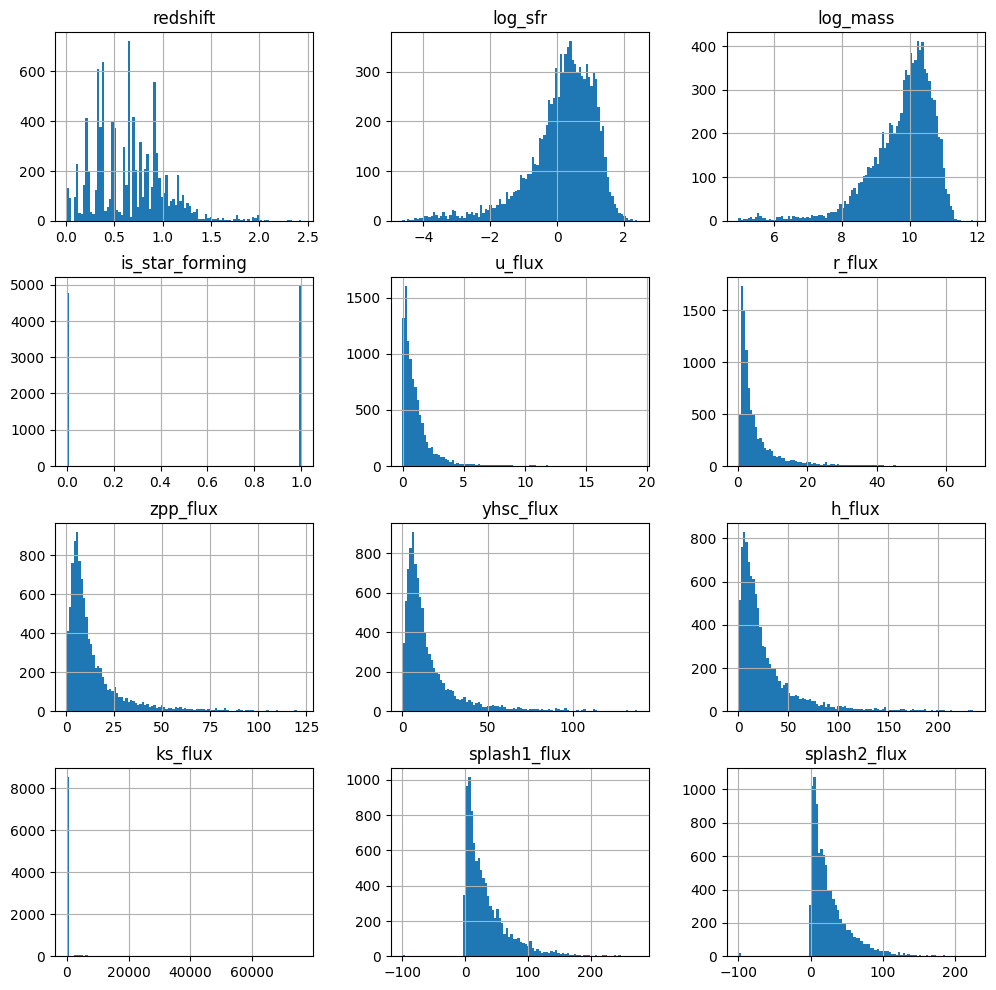

In [14]:
df_cleaned.hist(figsize=(12,12), bins=100)

Select a random sub-sample of the dataset. `PCA` does computations linearly, therefore it's quick and you can choose the whole dataset if you wish. Then take 1000 objects at random and break one of their features for them. Will our algorithsm manage to isolate these ourliers?

In [15]:
# select a random sub-sample of the dataset
n = 10000
idxs = np.arange(df_orig.shape[0])
idxs_rand = np.random.choice(idxs, size=n)
df = df_orig.iloc[idxs_rand] # dataframe

# take our data set to work with
X = df.values # array
y = df['is_star_forming']

# get column names
flux_cols = list(df_orig.columns[4:]) # flux column names
flux_idxs = np.argwhere(np.isin(df.columns, flux_cols)).flatten() # flux column indices

Now take the galaxy data (fluxes) and find out whether you can reduce it to a couple of meaningful principal components using `PCA`. By meaningful, we are interested in the method that is capable of separating galaxies into `star forming` or `dead`.

The user interface of the PCA in sklearn is the same as for all other similar classes (see PCA [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)). Complexity of PCA with full `svd` solve: $\mathcal{O}(n_{max}^2 n_{min})$, where $n_{max} = max(n_{samples}, n_{features})$, $n_{min} = min(n_{samples}, n_{features})$.

In [16]:
def plot_components(df, y_pcs, color_property, fig = None, ax = None, cmap='viridis', clabel=''):
    # set up the figure
    if fig is None and ax is None:
        fig, ax = plt.subplots(1, figsize=(10, 10), dpi=100)
    ax.set_xlim(np.percentile(y_pcs[:,0], 99), np.percentile(y_pcs[:,0], 1))
    ax.set_ylim(np.percentile(y_pcs[:,1], 99), np.percentile(y_pcs[:,1], 1))
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    
    # choose color property
    y_color = df[color_property]
    vmin, vmax = np.percentile(y_color, 99), np.percentile(y_color, 1)
   
    # plot galaxies
    sc = ax.scatter(y_pcs[:, 0], y_pcs[:, 1], s=0.02, 
                    c=y_color, cmap=cmap)#, vmin=vmin, vmax=vmax)
    
    # add colorbar
    cbar = plt.colorbar(sc)
    cbar.ax.set_ylabel(clabel, rotation=270, labelpad=10)
    return



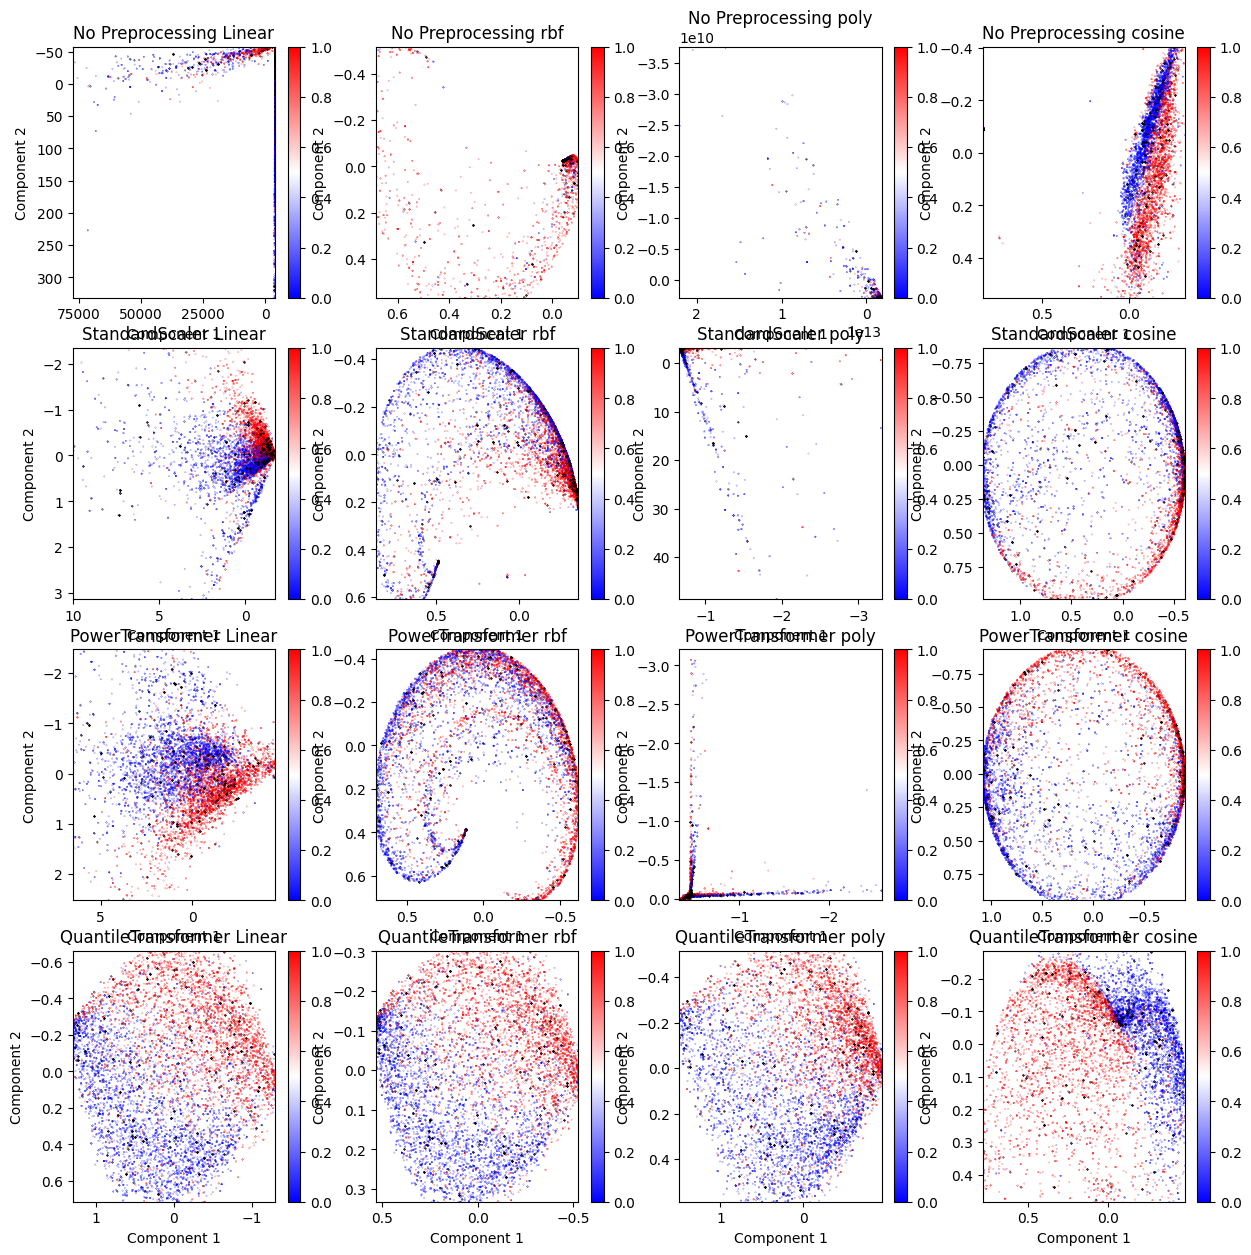

In [17]:
# PREPROCESS USING diff. scalers and PCA kernels and see what it does (also to outliers)

transform = preprocessing.StandardScaler()
transform_list = [None, preprocessing.StandardScaler(), preprocessing.PowerTransformer(), preprocessing.QuantileTransformer()]
pca_kernel_list = [KernelPCA(n_components=2,kernel='linear'), KernelPCA(n_components=2,kernel='rbf'),
                   KernelPCA(n_components=2,kernel='poly'), KernelPCA(n_components=2,kernel='cosine')]
name_list = ['No Preprocessing', 'StandardScaler', 'PowerTransformer', 'QuantileTransformer']
kernel_name_list = ['Linear', 'rbf', 'poly', 'cosine']
fig, ax = plt.subplots(nrows = len(name_list), ncols = len(kernel_name_list), figsize=(15,15))

for i,transform in enumerate(transform_list):
    if transform is None:
        X_std = X[:,flux_idxs].copy()
    else:
        X_std = transform.fit_transform(X[:,flux_idxs])
    for j, kernel in enumerate(pca_kernel_list):

        y_pcs = kernel.fit_transform(X_std) # train pca object
        ax[i,j].set(title = name_list[i] + ' ' + kernel_name_list[j])
        # plot new PCA results
        plot_components(df, y_pcs, color_property='is_star_forming', cmap='bwr', fig=fig, ax=ax[i,j])
        # plot outliers
        ax[i,j].scatter(y_pcs[idx_outlier_list,0], y_pcs[idx_outlier_list,1], s=0.08, color='k')
       

c:\Users\Simon Andersen\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Simon Andersen\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Simon Andersen\AppData\Lo

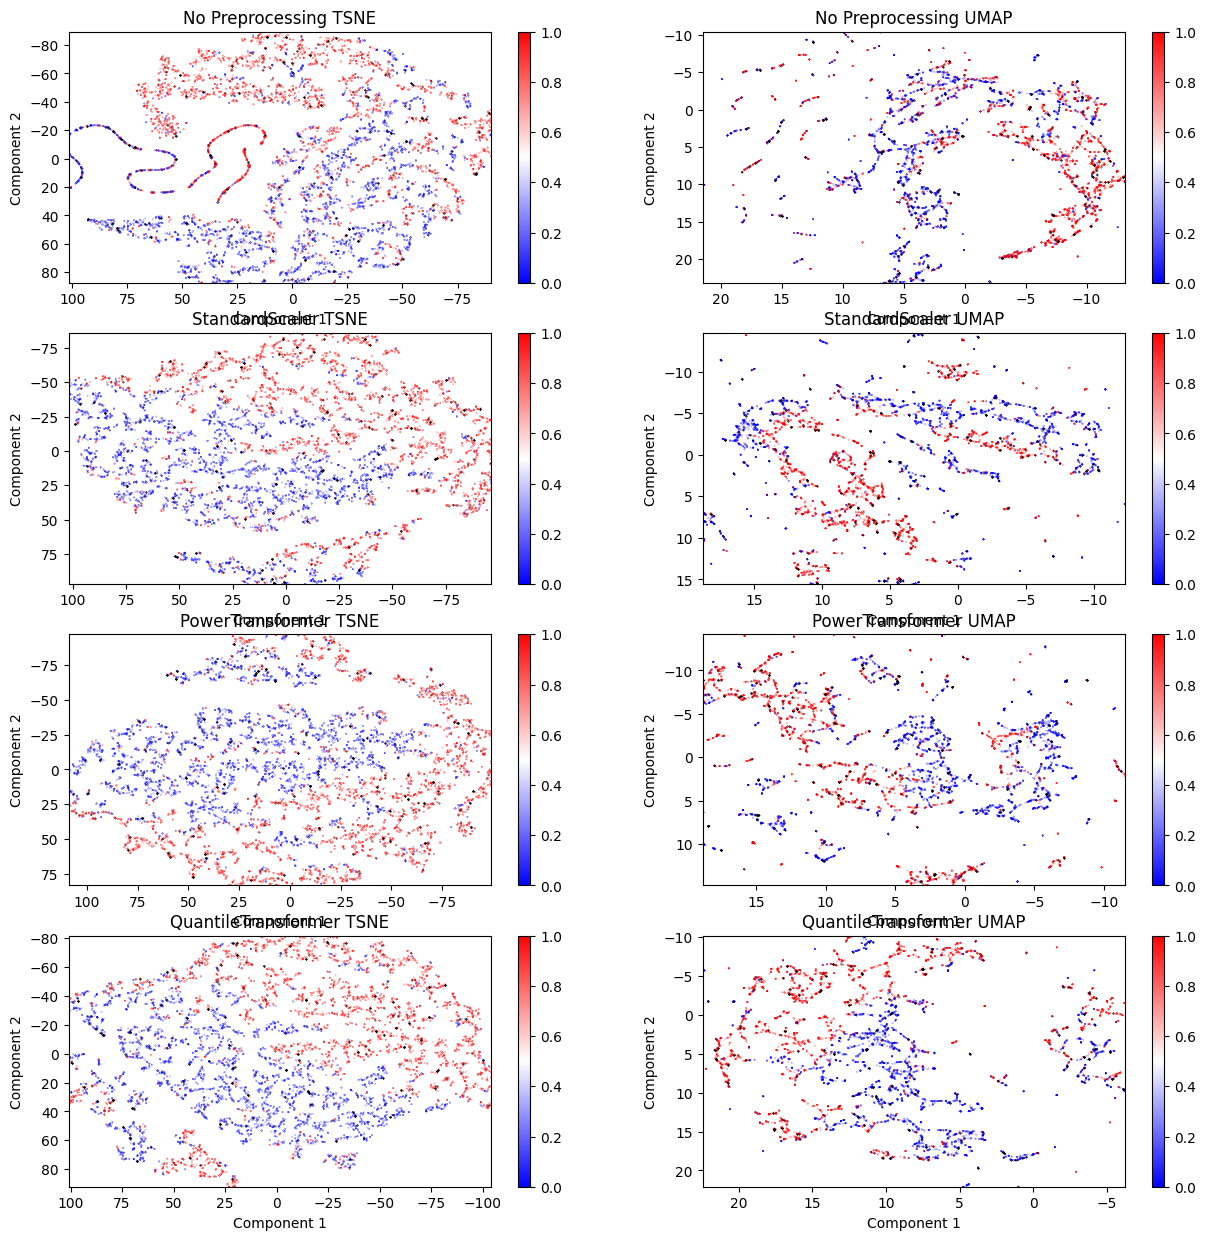

In [18]:
##NOW: Try using t-sne and umap instead
from sklearn.manifold import TSNE
import umap
# PREPROCESS USING diff. scalers and PCA kernels and see what it does (also to outliers)

transform = preprocessing.StandardScaler()
transform_list = [None, preprocessing.StandardScaler(), preprocessing.PowerTransformer(), preprocessing.QuantileTransformer()]
pca_kernel_list = [TSNE(), umap.UMAP()]
name_list = ['No Preprocessing', 'StandardScaler', 'PowerTransformer', 'QuantileTransformer']
kernel_name_list = ['TSNE', 'UMAP']
fig, ax = plt.subplots(nrows = len(name_list), ncols = len(kernel_name_list), figsize=(15,15))

for i,transform in enumerate(transform_list):
    if transform is None:
        X_std = X[:,flux_idxs].copy()
    else:
        X_std = transform.fit_transform(X[:,flux_idxs])
    for j, kernel in enumerate(pca_kernel_list):

        y_pcs = kernel.fit_transform(X_std) # train pca object
        ax[i,j].set(title = name_list[i] + ' ' + kernel_name_list[j])
        # plot new PCA results
        plot_components(df, y_pcs, color_property='is_star_forming', cmap='bwr', fig=fig, ax=ax[i,j])
        # plot outliers
        ax[i,j].scatter(y_pcs[idx_outlier_list,0], y_pcs[idx_outlier_list,1], s=0.08, color='k')
       

On the plots below we can overplot the now known outlier data points so we can judge explicitly whether the algorithms do a good job at finding these odd data.

Clearly, in the above dimensions we cannot draw a **decision boundary** to separate the living galaxies from the dead. Therefore, the classification is not physically meaningful to us. But out of curiosity, let us check the other physical properties, such as the galaxy mass `log_mass` and the rate of star formation `log_sfr`, as well:

Again, all objects are mixed together in not a helpful way... What about the last property, the `redshift`s? This feature is supposed to introduce a bias in the fluxes.

You can see that separation in `redshift` is better than for other properties. Therefore, the conclusion here is not that `PCA` is a particularly bad choice, but rather that it picks up the strongest signal affecting the data, which in this case turns out to be a systematic effect of the redshift. However, the data here has a continous (NOT discrete) distribution of redshift and therefore we should not expect to find separate clusters of data points. 

So, if we would like to reduce dimensions meaningfully in other properties of interest, we need to correct for the effect of redshift first. You will attempt to do this in the next session, when you will pay more attention to preprocessing and selection of hyperparameters.

For now, let us continue throwing these data at other algorithms to get some practice with them - `KernelPCA`.

Ok, the projections above are better than with the linear `PCA`, but still quite mixed. Below, you can see that the redshifts an apparent signal picked up by the non-linear PCA.

In [19]:
plot_components(y_pcs, color_property='redshift', 
                  cmap='jet', clabel='Redshift')

TypeError: plot_components() missing 1 required positional argument: 'y_pcs'

### t-SNE

Now, try to run `t-SNE` on the dataset (for examples or set-up see documentation for `t-SNE` on sklearn [website](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)). Use `perplexity=50, method='barnes_hut', n_iter=1000, random_state=42` for now. In the next class we will put more emphasis on the importance of the optimal values for theses parameters. Complexity of `t-SNE` (with approximate solver `barnes_hut`) is $\mathcal{O}(k n^2)$, where $k$ - number of output dimensions, $n$ - number of samples.

* How well does `t-SNE` help to differentiate between two classes here?

* Does you get clusters of galaxies or a continuum?

* Which physical property is the most distinctly separated in the reduced space?

In [ ]:
from sklearn.manifold import TSNE

# running t-SNE
# use the non-standardized data X[:, flux_idxs]
tsne = TSNE()
y_tsne = tsne.fit_transform(X)

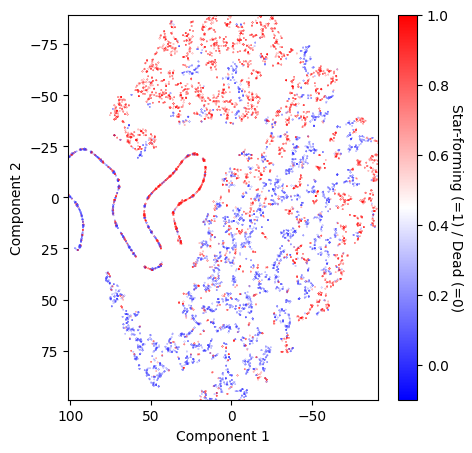

In [ ]:
plot_components(y_tsne, color_property='is_star_forming', 
                  cmap='bwr', clabel='Star-forming (=1) / Dead (=0)')

Now, the map produced with `t-SNE` is much more meaningful to us. It is not ideal and there are plenty of stray objects in either red or blue group, but we can even compute a decision boundary for these projections to do probably quite accurate classification. 

The black outliers come out very explicitly on the t-SNE mapping in s 'snake' pattern:

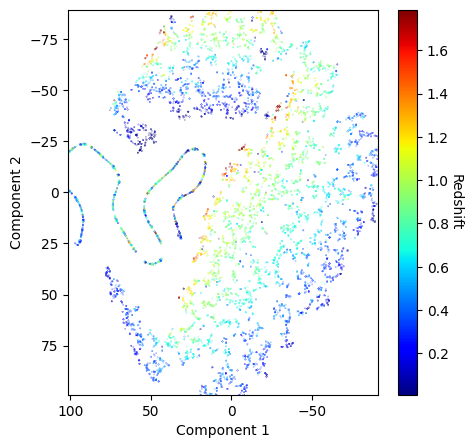

In [ ]:
plot_components(y_tsne, color_property='redshift', 
                  cmap='jet', clabel='Redshift')

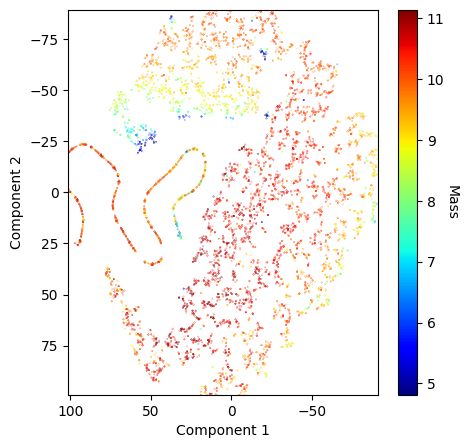

In [ ]:
plot_components(y_tsne, color_property='log_mass', 
                  cmap='jet', clabel='Mass')

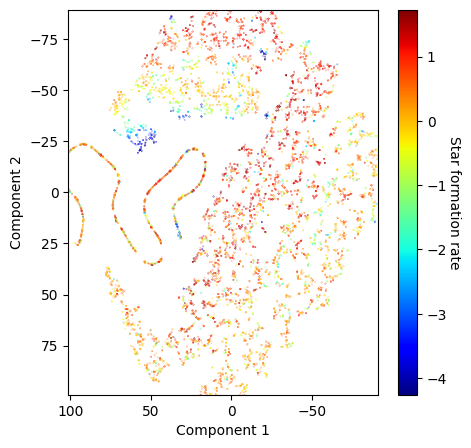

In [ ]:
plot_components(y_tsne, color_property='log_sfr', 
                  cmap='jet', clabel='Star formation rate')

### UMAP

Now try using `UMAP`. For documentation see the UMAP [webpage](https://umap-learn.readthedocs.io/en/latest/api.html). This has the same interface as the other embedding classes above. Use with `n_components=2, n_neighbors=50, random_state=42`. 

* Do you get something similar to `t-SNE`?

* How well can you map different properties in the reduced space?

* Do you get clusters or continuous distributions? Which physical property is the most strongly separable with `UMAP`?

In [22]:
import umap

# running UMAP
# use the non-standardized data X[:, flux_idxs]
map_obj = umap.UMAP()
y_umap = map_obj.fit_transform(X[:, flux_idxs])

c:\Users\Simon Andersen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


This probably is best at finding the outliers:

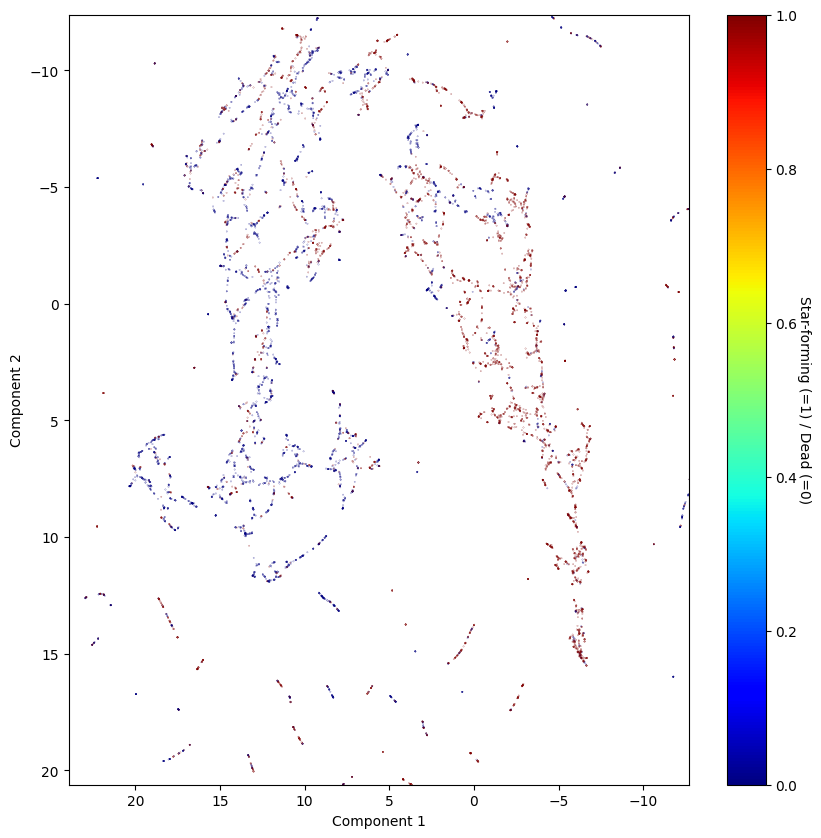

In [24]:
plot_components(df,y_umap, color_property='is_star_forming', 
                  cmap='jet', clabel='Star-forming (=1) / Dead (=0)')

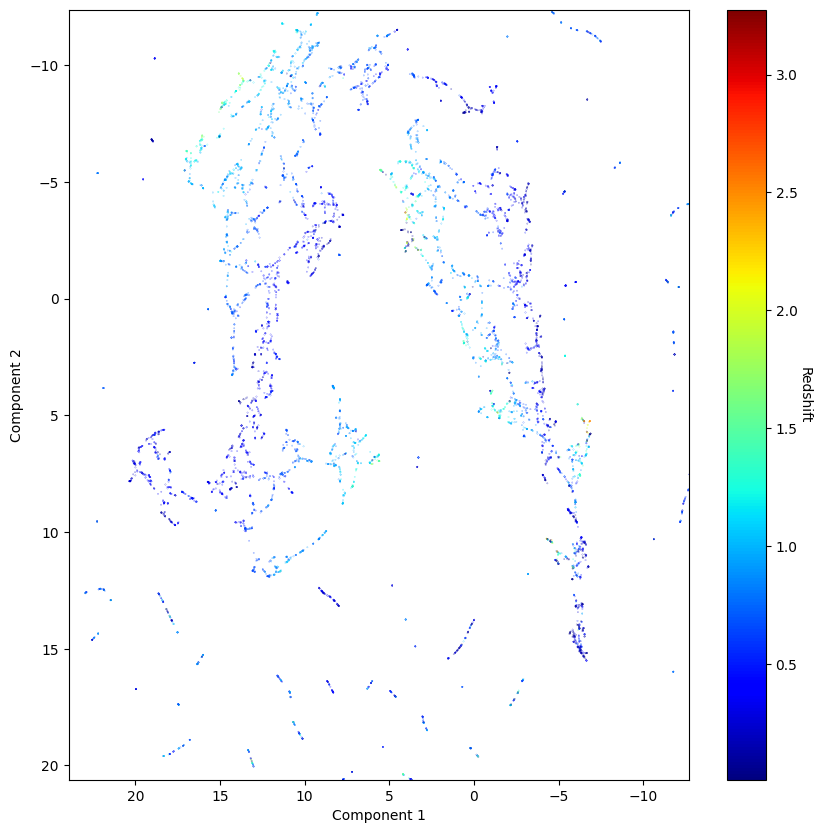

In [26]:
plot_components(df,y_umap, color_property='redshift', 
                  cmap='jet', clabel='Redshift')

In [ ]:
plot_components(y_umap, color_property='log_mass', 
                  cmap='jet', clabel='Mass')

In [ ]:
plot_components(y_umap, color_property='log_sfr', 
                  cmap='jet', clabel='Star formation rate')

If you are interested in seeing how different dimension reduction algorithms' complexities compare, see the plots here:

https://umap-learn.readthedocs.io/en/latest/benchmarking.html